In [1]:
from __future__ import division, print_function
%matplotlib inline
from utils import *
from keras.layers.merge import dot, add, concatenate
from pandas_summary import DataFrameSummary
import seaborn as sns

Using TensorFlow backend.


The goal is to predict the next order basket (list of products) for each user in the test set, given info about its prior orders.

# Set up data

Read data

In [8]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

Take a peak at the data

In [9]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
products_df

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


Collect order and product info for each user in the training set and then merge into a data frame df

In [14]:
df_train = orders_df.merge(order_products_train_df, how = 'inner', on = 'order_id')
df_train = df_train.merge(products_df, how = 'inner', on = 'product_id')
df_train.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [15]:
df_prior = orders_df.merge(order_products_prior_df, how = 'inner', on = 'order_id')
df_prior = df_prior.merge(products_df, how = 'inner', on = 'product_id')
df_prior.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [16]:
df = pd.concat([df_prior, df_train])

In [17]:
sample=int(1e5)
df = df.iloc[:sample]

In [18]:
#fillna
df.fillna(0,axis=0, inplace=True)
df.drop('eval_set', axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
del df_train, df_prior

In [21]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,1,2,8,0.0,196,1,0,Soda,77,7
1,2539329,1,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19
3,2539329,1,1,2,8,0.0,26088,4,0,Aged White Cheddar Popcorn,23,19
4,2539329,1,1,2,8,0.0,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17


# Engineer new features

## product  list per user

Create new user features encoding order/product info

In [22]:
#separate orders according to their eval_set
prior = orders_df[orders_df["eval_set"]=='prior']
train = orders_df[orders_df["eval_set"]=='train']
test = orders_df[orders_df["eval_set"]=='test']

#get user_ids and the number of users in each eval_set
user_ids_total, n_users_total = prior['user_id'].unique(), prior['user_id'].nunique()
user_ids_train, n_users_train = train['user_id'].unique(), train['user_id'].nunique()
user_ids_test, n_users_test = test['user_id'].unique(), test['user_id'].nunique()

del prior
print("n_users_total = {}, n_users_train = {}, n_users_test = {}".format(n_users_total, n_users_train, n_users_test))

n_users_total = 206209, n_users_train = 131209, n_users_test = 75000


In [23]:
#group by user_id and order_number (this takes ~4 minutes to run locally on the entire data set).
X = df.groupby(['user_id', 'order_number'])['product_id'].apply(lambda x : list(x)).reset_index()
X.columns = ['user_id', 'order_number', 'product_list']

In [24]:
X.head()

,user_id,order_number,product_list
0,1,1,"[196, 14084, 12427, 26088, 26405]"
1,1,2,"[196, 12427, 26088, 10258, 13176, 13032]"
2,1,3,"[196, 12427, 10258, 25133, 30450]"
3,1,4,"[196, 12427, 26405, 10258, 25133]"
4,1,5,"[196, 12427, 10258, 13176, 25133, 10326, 17122..."


In [25]:
from keras.preprocessing.sequence import pad_sequences
sequences = np.array(X.product_list)
maxlen = X.product_list.map(len).max()

# pad sequence
padded = pad_sequences(sequences, padding='post', maxlen= maxlen)

In [26]:
#now group by user_id 
X_users =X.groupby('user_id')['product_list'].apply(lambda x : list(x)).reset_index()
X_users['num_orders_per_user'] = X_users.product_list.map(len)
X_users['ave_num_prods_per_order'] = X_users.product_list.map(lambda L: [len(x) for x in L]).map(np.mean).map(round)
X_users.set_index('user_id',inplace = True)

In [ ]:
products_d

In [27]:
X_users.head()

,product_list,num_orders_per_user,ave_num_prods_per_order
user_id,,,
1,"[[196, 14084, 12427, 26088, 26405], [196, 1242...",10,6
2,"[[13176, 32792, 47766, 20574, 12000, 48110, 22...",14,14
3,"[[47766, 16797, 9387, 17668, 15143, 39190, 219...",12,7
4,"[[36606, 7350, 35469, 2707], [42329, 7160], [3...",5,4
5,"[[15349, 21413, 48775, 28289, 8518, 11777, 317...",4,9


In [28]:
X_users.shape

(667, 3)

## product rating per user

Create a new product 'rating' feature encoding the likelyhood of it being reordered by the user

In [24]:
#drop the first order for each user ('reodered' is meaningless in that case)
df2 = df[df['days_since_prior_order']!=0]

In [ ]:
g=df2.groupby(['user_id','product_name','product_id'])

In [ ]:
#create new data frame from df2
prod_ratings = df2.groupby(['user_id','product_name','product_id'])['reordered'].aggregate('sum').reset_index()

In [113]:
#reduce size of data
#prod_ratings = prod_ratings.iloc[0:100000]
prod_ratings.head()

,user_id,product_name,product_id,reordered
0,1,0% Greek Strained Yogurt,38928,1
1,1,Aged White Cheddar Popcorn,26088,2
2,1,Bag of Organic Bananas,13176,1
3,1,Bartlett Pears,41787,0
4,1,Cinnamon Toast Crunch,13032,3


Update product and user ids so that they are contiguous integers, which we want when using embeddings.

In [114]:
users = prod_ratings.user_id.unique()
prods = prod_ratings.product_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
prodid2idx = {o:i for i,o in enumerate(prods)}

prod_ratings.product_id = prod_ratings.product_id.apply(lambda x: prodid2idx[x])
prod_ratings.user_id = prod_ratings.user_id.apply(lambda x: userid2idx[x])

Apply StandardScaler (Subtract mean and divide by stdev) to the 'reordered' label 

In [115]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([('reordered', StandardScaler())], df_out=True)
prod_ratings.reordered = np.round(mapper.fit_transform(prod_ratings.copy()), 2)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [116]:
prod_ratings.head()

,user_id,product_name,product_id,reordered
0,0,0% Greek Strained Yogurt,0,-0.11
1,0,Aged White Cheddar Popcorn,1,0.18
2,0,Bag of Organic Bananas,2,-0.11
3,0,Bartlett Pears,3,-0.40
4,0,Cinnamon Toast Crunch,4,0.47


In [117]:
user_min, user_max, movie_min, movie_max = (prod_ratings.user_id.min(), 
    prod_ratings.user_id.max(), prod_ratings.product_id.min(), prod_ratings.product_id.max())
user_min, user_max, movie_min, movie_max

(0, 1546, 0, 19057)

In [118]:
n_users = prod_ratings.user_id.nunique()
n_prods = prod_ratings.product_id.nunique()

n_users, n_prods

(1547, 19058)

This is the number of latent factors in each embedding.

In [135]:
n_factors = 50

In [136]:
np.random.seed = 42

Randomly split into training and validation.

In [137]:
msk = np.random.rand(len(prod_ratings)) < 0.8
trn = prod_ratings[msk]
val = prod_ratings[~msk]

##  Simple Model using embeddings in Keras

In [138]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [139]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-3)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 1e-3)

In [140]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [141]:
ub = create_bias(user_in, n_users)
pb = create_bias(prod_in, n_prods)

In [142]:
x = dot([u, p], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, pb])
model = Model([user_in, prod_in], x)
model.compile(Adam(0.001), loss='mse')

In [143]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=1, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 80109 samples, validate on 19891 samples
Epoch 1/1
80109/80109 [==============================] - 21s - loss: 0.9724 - val_loss: 0.9576


In [144]:
model.optimizer.lr=0.01

In [145]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=6, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 80109 samples, validate on 19891 samples
Epoch 1/6
80109/80109 [==============================] - 21s - loss: 0.9046 - val_loss: 0.9261
Epoch 2/6
80109/80109 [==============================] - 21s - loss: 0.8695 - val_loss: 0.9084
Epoch 3/6
80109/80109 [==============================] - 24s - loss: 0.8457 - val_loss: 0.8977
Epoch 4/6
80109/80109 [==============================] - 25s - loss: 0.8284 - val_loss: 0.8912
Epoch 5/6
80109/80109 [==============================] - 24s - loss: 0.8152 - val_loss: 0.8873
Epoch 6/6
80109/80109 [==============================] - 23s - loss: 0.8049 - val_loss: 0.8855


In [146]:
model.optimizer.lr=0.001

In [147]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=10, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 80109 samples, validate on 19891 samples
Epoch 1/10
80109/80109 [==============================] - 24s - loss: 0.7964 - val_loss: 0.8840
Epoch 2/10
80109/80109 [==============================] - 25s - loss: 0.7894 - val_loss: 0.8836
Epoch 3/10
80109/80109 [==============================] - 23s - loss: 0.7835 - val_loss: 0.8835
Epoch 4/10
80109/80109 [==============================] - 25s - loss: 0.7783 - val_loss: 0.8836
Epoch 5/10
80109/80109 [==============================] - 25s - loss: 0.7739 - val_loss: 0.8844
Epoch 6/10
80109/80109 [==============================] - 25s - loss: 0.7698 - val_loss: 0.8851
Epoch 7/10
80109/80109 [==============================] - 24s - loss: 0.7663 - val_loss: 0.8857
Epoch 8/10
80109/80109 [==============================] - 24s - loss: 0.7632 - val_loss: 0.8868
Epoch 9/10
80109/80109 [==============================] - 24s - loss: 0.7602 - val_loss: 0.8875
Epoch 10/10
80109/80109 [==============================] - 25s - loss: 0.7576 - val_lo

In [148]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=5, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 80109 samples, validate on 19891 samples
Epoch 1/5
80109/80109 [==============================] - 24s - loss: 0.7552 - val_loss: 0.8893
Epoch 2/5
80109/80109 [==============================] - 23s - loss: 0.7529 - val_loss: 0.8904
Epoch 3/5
80109/80109 [==============================] - 25s - loss: 0.7508 - val_loss: 0.8914
Epoch 4/5
80109/80109 [==============================] - 23s - loss: 0.7489 - val_loss: 0.8924
Epoch 5/5
80109/80109 [==============================] - 23s - loss: 0.7471 - val_loss: 0.8936


In [152]:
model.save_weights('models/simplemodel.h5')

In [153]:
model.load_weights('models/simplemodel.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a product id. For instance, this predicts that user #0 is likely to reorder product #15 (soda) and not likely to reorder product #12 (organic whole milk).

In [159]:
model.predict([np.array([0]), np.array([16])]), model.predict([np.array([0]), np.array([13])])

(array([[ 0.6457]], dtype=float32), array([[ 1.3297]], dtype=float32))

In [155]:
prod_ratings

,user_id,product_name,product_id,reordered
0,0,0% Greek Strained Yogurt,0,-0.11
1,0,Aged White Cheddar Popcorn,1,0.18
2,0,Bag of Organic Bananas,2,-0.11
3,0,Bartlett Pears,3,-0.40
4,0,Cinnamon Toast Crunch,4,0.47
5,0,Creamy Almond Butter,5,-0.40
6,0,Honeycrisp Apples,6,-0.40
7,0,Milk Chocolate Almonds,7,-0.11
8,0,Organic Fuji Apples,8,-0.40
9,0,Organic Half & Half,9,0.18


## Analyze results

For simplicity, we restict the analysis to the top 2000 most popular products.

In [165]:
g=prod_ratings.groupby('product_id')['reordered'].count()
topProds=g.sort_values(ascending=False)[:2000]
topProds = np.array(topProds.index)

In [190]:
topProds

array([  24,    2,  154, ...,  744, 5189, 3390])

Let us first look at the product bias term. We create a model using the functional API. Our input is the product id and the output is the product bias term.

In [181]:
prod_names = prod_ratings['product_name'].to_dict

In [193]:
#top product is banana
prod_names()[topProds[0]]

'Banana'

In [194]:
get_prod_bias = Model(prod_in, pb)
prod_bias = get_prod_bias.predict(topProds)
product_ratings = [(b[0], prod_names()[prods[i]]) for i,b in zip(topProds,prod_bias)]

Now we can look at the top and bottom rated products. These ratings take into account user sentiment, as well as different types of producst that different users reorder.

In [195]:
sorted(product_ratings, key=itemgetter(0))[:15]

[(-0.68483967, 'Spinach'),
 (-0.66879153, 'Frozen Broccoli Florets'),
 (-0.53963488, 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz'),
 (-0.52844012, 'Organic Black Beans'),
 (-0.51432961, 'Seasoned Chicken Fry Batter Mix'),
 (-0.51392204, 'Organic Beans And Cheese Burrito'),
 (-0.51139426, 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'),
 (-0.50461668, 'Mini Double Caramel Ice Cream Bars'),
 (-0.50375521, 'Organic Cream Cheese Bar'),
 (-0.5030793, 'Reduced Fat Irish Butter'),
 (-0.50286722, 'Seasoning Bay Leaf'),
 (-0.50137478, 'Beer'),
 (-0.50043839, 'Total 0% Greek Yogurt'),
 (-0.4955267, 'Hawaiian Breeze and Vanilla Passion Fruit 2-in-1 Candle'),
 (-0.48716488, 'Mild Red Enchilada Sauce')]

In [196]:
sorted(product_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.1003503, 'Intensive Care Cocoa Radiant Lotion'),
 (0.92698514, 'Banana'),
 (0.833215, 'Nonfat Icelandic Style Strawberry Yogurt'),
 (0.82355499, 'Kettle Style Sweet Maui Onion Potato Chips'),
 (0.81986839, 'Bag of Organic Bananas'),
 (0.81064606, 'Unsweetened Watermelon Water'),
 (0.78022283, 'Organic Whole Milk'),
 (0.7734192, 'Table Water Crackers with Cracked Pepper'),
 (0.76904273, 'Original Key Lime Pie Yogurt'),
 (0.76465553, 'China Green Tips Green Tea'),
 (0.7511853, 'Alpine Spring Water'),
 (0.71296746, 'Mandarin Oranges'),
 (0.69823372, 'Premium Solid White Albacore Tuna in Water'),
 (0.69281495, 'Ranch Dressing'),
 (0.68892491, 'Organic Baby Arugula')]

We can now do the same thing for the embeddings.

In [197]:
get_prod_emb = Model(prod_in, p)
prod_emb = np.squeeze(get_prod_emb.predict([topProds]))
prod_emb.shape

(2000, 100)

Because it's hard to interpret 100 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [198]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
prod_pca = pca.fit(prod_emb.T).components_

In [199]:
fac0 = prod_pca[0]

In [200]:
prod_comp = [(f, prod_names()[prods[i]]) for f,i in zip(fac0, topProds)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [201]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.057998200755658175, 'Organic Broccoli'),
 (0.04655566570169533, 'Tamari Gluten Free Soy Sauce'),
 (0.044916037327463174, 'Light Spread Butter Substitute'),
 (0.040458213371650197, 'Dried Sweetened Cranberries'),
 (0.040180965118022903, '85% Lean Ground Beef'),
 (0.039364458080203162, 'Organic Refried Black Beans'),
 (0.037786270996578983, 'Total 2% Lowfat Plain Greek Yogurt'),
 (0.037103915601006732, '100% Pure Eucalyptus Essential Oil'),
 (0.034049299473899793, 'Plain Whole Milk Yogurt'),
 (0.032488596804408909, 'Organic SprouTofu Silken Tofu')]

In [202]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.3655462912487541, 'Banana'),
 (-0.20274195753288568, 'Organic Kiwi'),
 (-0.18050606717920115, 'Parsley'),
 (-0.17992331877779169, 'Organic Whole Milk'),
 (-0.17594861389438468, 'Bag of Organic Bananas'),
 (-0.1701812785120552, 'Organic Packham Or Anjou Pears'),
 (-0.16399747953680302, 'Organic Baby Spinach'),
 (-0.15455060178943736, 'Granny Smith Apples'),
 (-0.14984118317452774, 'Limes'),
 (-0.1467360080333435, 'Organic Granny Smith Apple')]

In [204]:
fac1 = prod_pca[1]

In [205]:
prod_comp = [(f, prod_names()[prods[i]]) for f,i in zip(fac1, topProds)]

The 2nd is 'hollywood blockbuster'.

In [206]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.46973019457269805, 'Bag of Organic Bananas'),
 (0.20888142909041951, 'Organic Baby Spinach'),
 (0.12254528208438059, 'Organic Packham Or Anjou Pears'),
 (0.11909096031696531, 'Organic Granny Smith Apple'),
 (0.10433095857006015, 'China Green Tips Green Tea'),
 (0.084094691313842909, 'Goat Cheese Log'),
 (0.082282504247520788, 'Chocolate & Peanut Butter Shell Topping'),
 (0.081541412069106228, 'Red Vine Tomato'),
 (0.081003771862325394, 'Sharp Cheddar Cheese'),
 (0.078475269206271681, 'Unsalted Butter')]

In [207]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.41323934290238679, 'Banana'),
 (-0.10045932002761937, 'Organic Shredded Unsweetened Coconut'),
 (-0.094683940578290965, 'Limes'),
 (-0.092128675187085327, 'Variety Pack Ice Cream Bars'),
 (-0.081681581397407402, 'Walnut Halves & Pieces'),
 (-0.078884132541184371, 'The Original Worcestershire Sauce'),
 (-0.078664966260609009, 'Expressions Facial Tissue'),
 (-0.076684553766778907, 'Homestyle Classics Meatloaf'),
 (-0.07461939027367756, 'Uncured Genoa Salami'),
 (-0.06958477522711623, 'Organic Blackberries')]

In [210]:
fac2 = prod_pca[2]

In [211]:
prod_comp = [(f, prod_names()[prods[i]]) for f,i in zip(fac2, topProds)]

The 3rd is 'violent vs happy'.

In [212]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.24474396289808431, 'Granny Smith Apples'),
 (0.18806102852457507, 'Organic Basil'),
 (0.17959289481743937, 'Organic Yellow Peaches'),
 (0.17878793995675862, 'Limes'),
 (0.16051815742618078, 'Large Burrito Flour Tortillas'),
 (0.14876265963435936, 'Organic Hearty Split Pea & Uncured Ham Soup'),
 (0.12814142569489462, 'Pure Baking Soda'),
 (0.12434003051544884, 'Italian Extra Virgin Olive Oil'),
 (0.12403299385514946, 'Seasoning Allspice'),
 (0.12030949290721116, 'Pure & Natural Sour Cream')]

In [213]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.19463029253144556, 'Organic Whole Milk'),
 (-0.17583337475332556, 'Organic Kiwi'),
 (-0.16985176483456876, 'Organic Baby Spinach'),
 (-0.15280492777382401, 'Organic All Day Fresh Deodorant Lavender'),
 (-0.11487803640994276, 'Parsley'),
 (-0.10459479601461162, 'Organic Lightly Salted Brown Rice Cakes'),
 (-0.099818240592249613, 'Organic Turkey Bacon'),
 (-0.091125085578571255, 'Bag of Organic Bananas'),
 (-0.083561381271361604, 'Banana'),
 (-0.082388739965689642, 'Unsalted Cultured Butter')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [75]:
# The following would be for Python 2 only
# reload(sys)
# sys.setdefaultencoding('utf8')

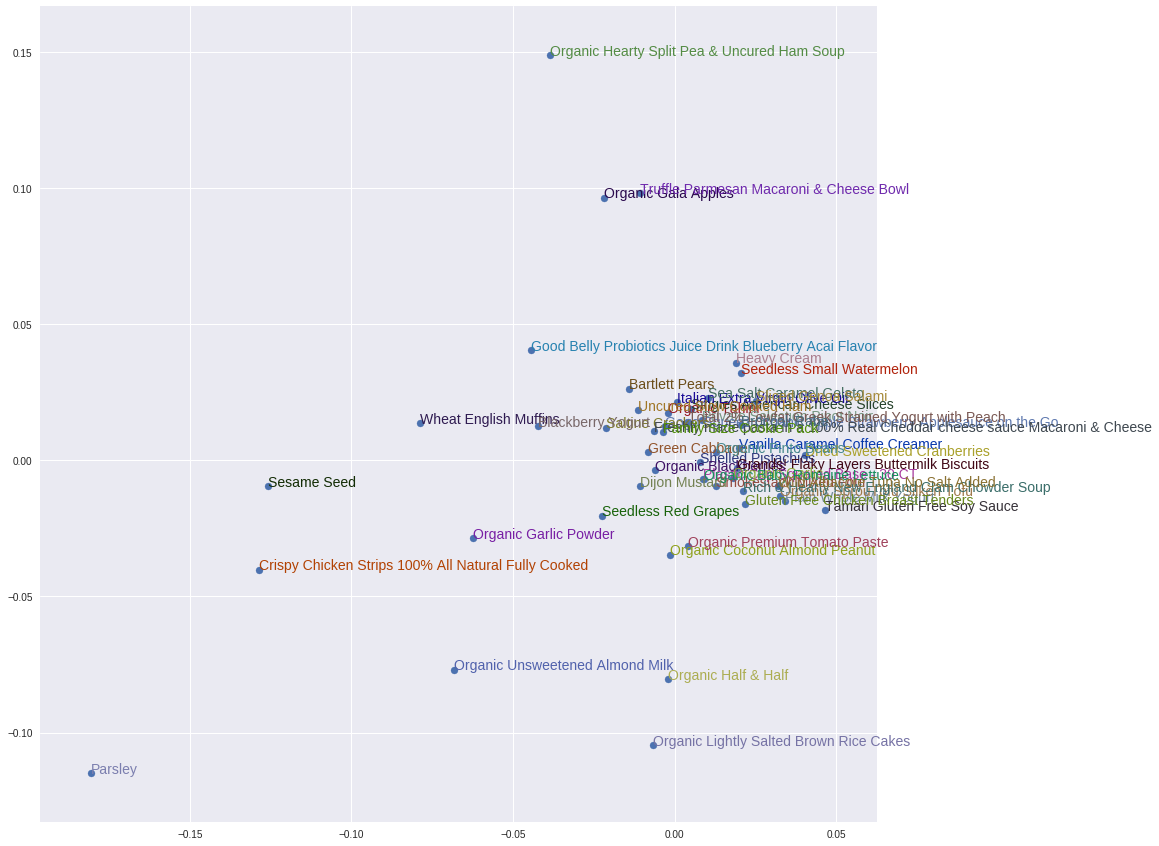

In [214]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topProds[start:end], X, Y):
    plt.text(x,y,prod_names()[prods[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

We now concatenate the user and product embeddings into a single vector, which we then feed into the neural net.

In [34]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [35]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-3)
prod_in, p = embedding_input('movie_in', n_prods, n_factors, 1e-3)

In [36]:
x = concatenate([u, p], axis=2)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, prod_in], x)
nn.compile(Adam(0.001), loss='mse', metrics=['accuracy'])

In [45]:
nn.fit([prod_ratings.user_id, prod_ratings.product_id], prod_ratings.reordered, batch_size=64,
       epochs=3, validation_split=0.33, verbose =1)

Train on 67000 samples, validate on 33000 samples
Epoch 1/3
67000/67000 [==============================] - 26s - loss: 0.8942 - acc: 0.0000e+00 - val_loss: 1.0235 - val_acc: 0.0000e+00
Epoch 2/3
67000/67000 [==============================] - 26s - loss: 0.8820 - acc: 0.0000e+00 - val_loss: 1.0359 - val_acc: 0.0000e+00
Epoch 3/3
67000/67000 [==============================] - 26s - loss: 0.8790 - acc: 0.0000e+00 - val_loss: 1.0446 - val_acc: 0.0000e+00


In [46]:
#nn.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=3, 
#          validation_data=([val.user_id, val.product_id], val.reordered))

In [39]:
nn.optimizer.lr=0.01

In [47]:
nn.fit([prod_ratings.user_id, prod_ratings.product_id], prod_ratings.reordered, batch_size=64,
       epochs=6, validation_split=0.33, verbose =1)

Train on 67000 samples, validate on 33000 samples
Epoch 1/6
67000/67000 [==============================] - 27s - loss: 0.8725 - acc: 0.0000e+00 - val_loss: 1.0568 - val_acc: 0.0000e+00
Epoch 2/6
67000/67000 [==============================] - 27s - loss: 0.8784 - acc: 0.0000e+00 - val_loss: 1.0526 - val_acc: 0.0000e+00
Epoch 3/6
67000/67000 [==============================] - 27s - loss: 0.8675 - acc: 0.0000e+00 - val_loss: 1.0521 - val_acc: 0.0000e+00
Epoch 4/6
67000/67000 [==============================] - 26s - loss: 0.8763 - acc: 0.0000e+00 - val_loss: 1.0581 - val_acc: 0.0000e+00
Epoch 5/6
67000/67000 [==============================] - 26s - loss: 0.8622 - acc: 0.0000e+00 - val_loss: 1.0561 - val_acc: 0.0000e+00
Epoch 6/6
67000/67000 [==============================] - 26s - loss: 0.8698 - acc: 0.0000e+00 - val_loss: 1.0515 - val_acc: 0.0000e+00


In [221]:
nn.optimizer.lr=0.01

In [48]:
nn.fit([prod_ratings.user_id, prod_ratings.product_id], prod_ratings.reordered, batch_size=64,
       epochs=5, validation_split=0.33, verbose =1)

Train on 67000 samples, validate on 33000 samples
Epoch 1/5
67000/67000 [==============================] - 26s - loss: 0.8672 - acc: 1.4925e-05 - val_loss: 1.0545 - val_acc: 0.0000e+00
Epoch 2/5
67000/67000 [==============================] - 26s - loss: 0.8778 - acc: 0.0000e+00 - val_loss: 1.0521 - val_acc: 0.0000e+00
Epoch 3/5
67000/67000 [==============================] - 26s - loss: 0.8563 - acc: 0.0000e+00 - val_loss: 1.0531 - val_acc: 0.0000e+00
Epoch 4/5
67000/67000 [==============================] - 27s - loss: 0.8703 - acc: 0.0000e+00 - val_loss: 1.0562 - val_acc: 0.0000e+00
Epoch 5/5
67000/67000 [==============================] - 27s - loss: 0.8734 - acc: 0.0000e+00 - val_loss: 1.0581 - val_acc: 0.0000e+00


In [49]:
nn.optimizer.lr=0.001

In [50]:
nn.fit([prod_ratings.user_id, prod_ratings.product_id], prod_ratings.reordered, batch_size=64,
       epochs=10, validation_split=0.33, verbose =1)

Train on 67000 samples, validate on 33000 samples
Epoch 1/10
67000/67000 [==============================] - 27s - loss: 0.8613 - acc: 0.0000e+00 - val_loss: 1.0545 - val_acc: 0.0000e+00
Epoch 2/10
67000/67000 [==============================] - 27s - loss: 0.8685 - acc: 0.0000e+00 - val_loss: 1.0548 - val_acc: 0.0000e+00
Epoch 3/10
67000/67000 [==============================] - 26s - loss: 0.8648 - acc: 0.0000e+00 - val_loss: 1.0556 - val_acc: 0.0000e+00
Epoch 4/10
67000/67000 [==============================] - 26s - loss: 0.8591 - acc: 0.0000e+00 - val_loss: 1.0593 - val_acc: 0.0000e+00
Epoch 5/10
67000/67000 [==============================] - 26s - loss: 0.8714 - acc: 0.0000e+00 - val_loss: 1.0542 - val_acc: 0.0000e+00
Epoch 6/10
67000/67000 [==============================] - 26s - loss: 0.8596 - acc: 0.0000e+00 - val_loss: 1.0549 - val_acc: 0.0000e+00
Epoch 7/10
67000/67000 [==============================] - 26s - loss: 0.8561 - acc: 0.0000e+00 - val_loss: 1.0570 - val_acc: 0.0000e+0

In [223]:
model.save_weights('models/nn.h5')

In [53]:
nn.predict([np.array([0]), np.array([15])]), nn.predict([np.array([0]), np.array([12])])

(array([[ 0.1351]], dtype=float32), array([[ 0.5515]], dtype=float32))

Submit

In [47]:
test_index = test.sort_values('order_id', axis=0).index
train_index = train.sort_values('order_id', axis=0).index

In [48]:
df

NameError: name 'df' is not defined